## Actividad M1
Juan Manuel González Ascencio 
A00572003

## Descripción del problema
Se tiene que crear un programa el cual tenga como entrada un matriz de MxN, la cual tenga un porcentaje de celdas sucias que un numero de agentes tengan que limpiar.

Las aspiradoras (agentes) se moveran empezaran en la posición [1,1] en caso de encontrase en un celda sucia la limpiarán, si la celda ya esta limpia se mueven de manera aleatoria a una de sus 8 celdas vecinas.

In [10]:
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid
from mesa.space import SingleGrid

# Con ''SimultaneousActivation, hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import SimultaneousActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class RoombaAgent(Agent):
    def __init__(self, unique_id, model) -> None:
        super().__init__(unique_id, model)
    
    def step(self):
        (x,y) = self.pos
        
        #self.state = self.next_state
        #self.next_state = None
        neigbhors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        neighborhood = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        #print("Vecinos: ", neighborhood)
        
        #Si la celda en la que se encuentra, esta sucia (0) la limpia (1).
        
        if self.model.estados[x][y] == 0:
            self.model.estados[x][y] = 1
            #print("Se limpio la celda: ", self.pos)
        #Si la celda esta limpia, debe de seleccionar de manera aleatoria a uno de sus vecinos, ver si no esta ocupado y moverse a esa celda.
        else:
            (ranX, ranY) = self.random.choice(neighborhood)
            if self.model.grid.is_cell_empty((ranX, ranY)) and not self.model.grid.out_of_bounds((ranX, ranY)):
                self.model.grid.move_agent(self, (ranX, ranY))



In [3]:
def getGrid(model):
    #Creamos una copia de la matriz de estados 
    return np.copy(model.estados)
    

In [4]:
class RoombaModel(Model):
    def __init__(self, N, width, height, porcentajeSucias, maxSteps):
        self.num_agents = N #Número de agentes
        self.grid = MultiGrid(width, height, False) #Creamos el grid
        self.schedule = SimultaneousActivation(self) #Creamos la activación de los agentes
        self.estados = np.zeros((width, height)) #Creamos la matriz de estados
        self.estados_limpios = self.initMatrix() #Inicializamos la matriz de estados
        self.floor = np.zeros((width, height)) #Creamos la matriz de piso
        self.cleanned_cells = 0 #Creamos la variable para contar las celdas limpias
        self.porcentaje_sucias = porcentajeSucias #Creamos la variable para el porcentaje de celdas sucias
        self.cells_to_cover = 0 #Creamos la variable para contar las celdas a cubrir
        self.calculate_cells_to_cover() #Calculamos las celdas a cubrir


        #set floor
        for i in range(width):
            for j in range(height):
                if np.random.random() < porcentajeSucias:
                    self.floor[i][j] = 1

        # Creamos los agentes
        for i in range(self.num_agents):
            a = RoombaAgent(i, self)
            self.schedule.add(a)

            # Colocamos los agentes en la posición 1,1
            self.grid.place_agent(a, (1,1))

        # Creamos el DataCollector para obtener información de cada paso de la simulación.
        self.datacollector = DataCollector(
            model_reporters={"Grid": getGrid}
            #agent_reporters={"State": "state"}
        )

    def countDirty(self):
        return np.count_nonzero(self.estados == 0)
    
    def getPercClean(self):
        return (self.countDirty() / self.estados.size) * 100
    
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    
    #Función para inicializar la matriz de estados con valores aleatorios.
    def initMatrix(self):
        diezPorciento = int(self.estados.size * (1- self.porcentaje_sucias))
        totalSize = self.grid.width * self.grid.height
        indices = np.random.choice(totalSize, diezPorciento, replace=False)
        #remplazar los indices en la matriz de estados por 1
        for indice in indices:
            x = indice // self.grid.width
            y = indice % self.grid.height
            self.estados[x][y] = 1
        #print(self.estados)
        return self.estados
    
    
    
    
    
        

In [5]:
WIDTH = 10
HEIGHT = 10
N = 2 
MAX_STEPS = 100
PORCENTAJE_SUCIAS = 0.9
DATA_FRAME = {}
REPEAT_ALGO = 0


while REPEAT_ALGO < 1 :
    TOTAL_STEPS = 0
    IS_CLEANED = False
    PERCENTAGE_CLEANED = 0.0
    CELLS_COVERED = 0
    MODEL = RoombaModel(N, WIDTH, HEIGHT, PORCENTAJE_SUCIAS, MAX_STEPS)
    for i in range(MAX_STEPS):
        MODEL.step()
        CELLS_COVERED = MODEL.countDirty()
        if CELLS_COVERED == 0:
            IS_CLEANED = True
            TOTAL_STEPS = i
            PERCENTAGE_CLEANED = MODEL.getPercClean()
            break

In [6]:
all_grid = model.datacollector.get_model_vars_dataframe()

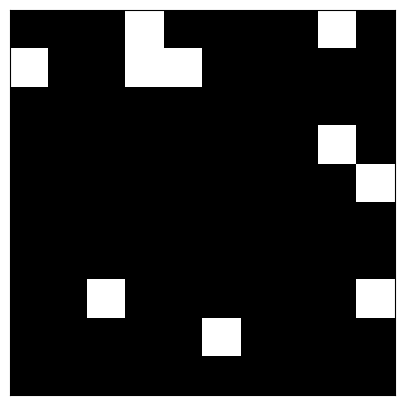

In [7]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary_r)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=STEPS)

In [9]:
anim